# Converting Images into Paint-by-Numbers

A paint-by-numbers kit provides individuals the opportunity to create beautiful paintings with little to no painting experience. The individual is provided a picture with outlined and numbered sections. Each number corresponds to one of the provided paint colors. The individual proceeds by painting all the numbered sections with the corresponding paint colors, resulting in a final painting. Typically, paint-by-number kits use very simple and standard pictures. In this notebook it will be shown how any picture can be converted into a paint-by-numbers, ready to be printed and used.

<img src="..\images\paint_by_numbers_example.jpg" width="620" height="620" align="center"/>

The process of converting an image into a paint-by-numbers can be broken down into 5 steps. 
1. Preprocessing the image - smoothening the image improves the quality of the outputted paint-by-numbers as will be shown later.
2. Quantising/Clustering the image - finding a reduced set of colors that could be used to accurately represent the image.
3. Recoloring the image - replace the color of each pixel in the image with the closest color within the reduced set of colors.
4. Outline the different colored sections.
5. Replace the color in each sectioned with the corresponding number in the centre of each section.

### 1. Preprocessing - Smoothening the Input Image
To demonstrate how the functions in this repository work, this simple still life image below will be used.

<img src="../images/still_life.jpg" width="360" height="360" align="center"/>

To understand the importance of preprocessing the image, we will execute a function that quantises the image, recolors the image, and outlines the different sections. Each part of the function will be explained in further detail later and will be improved upon. This will help visualise the difference in the output with and without image preprocessing.

First we need to import the required libraries:

In [1]:
from matplotlib import pyplot as plt
from matplotlib import image as img

Now we can import the image and show the imported image. A very simple image is used for demonstration purposes.

In [2]:
pic_path = "../images/still_life.jpg" # Path location of the image.
img_arr = img.imread(pic_path) # Reading image as a numpy array

We can now define the function to quantise the image.

In [3]:
def quantise_image(img_array, num_of_clusters):
    height, width, colors = img_array.shape
    img_2D = img_array.reshape(height*width, colors)
    cluster_model = KMeans(n_clusters=num_of_clusters)
    data_labels = cluster_model.fit_predict(img_2D)
    cluster_centers = cluster_model.cluster_centers_.round(0).astype(np.uint8)
    new_img = cluster_centers[data_labels].reshape(height, width, colors)
    return new_img, data_labels.reshape(height, width), cluster_centers

Using the above function, the code below quantises the raw image as well as an image after it has been smoothened using the OpenCV library. Additionally, we provide the outlined images so that the differences can be seen more clearly.

Text(0.5, 1.0, 'Image Outlines with Smoothening')

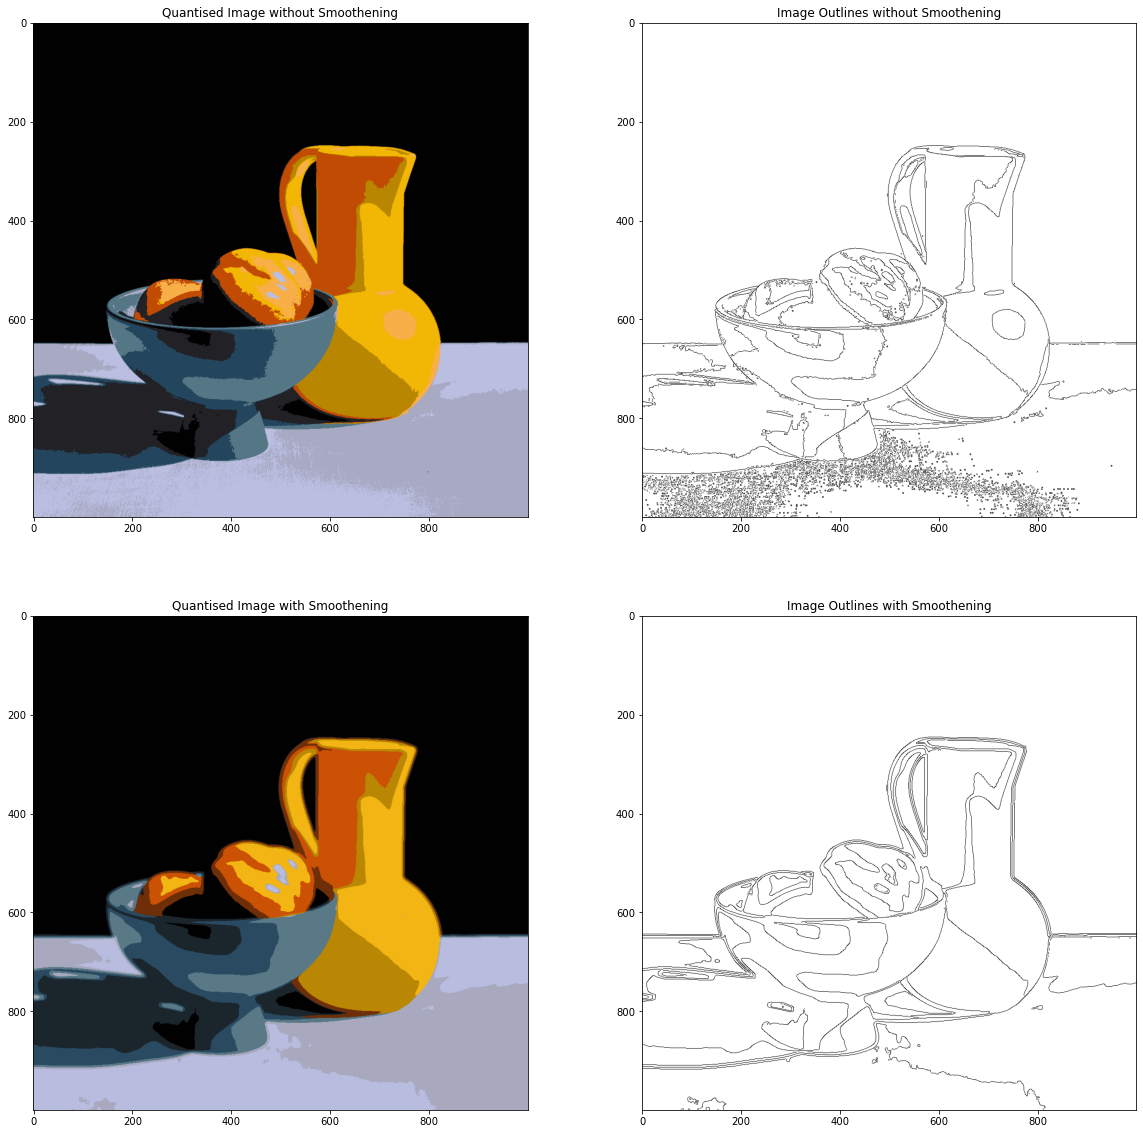

In [4]:
import cv2
from sklearn.cluster import KMeans
import numpy as np

# Quantise image using the raw image as an input
quant_img, data_labels, centers = quantise_image(img_arr, 10)
edge_img = cv2.Canny(quant_img, 0, 1)
#Quantise image using a smoothened image using image preprocessing techniques
smooth_img = cv2.blur(img_arr, (10, 10))
quant_smth_img, labels_smth, centers_smth = quantise_image(smooth_img, 10)
edge_smth_img = cv2.Canny(quant_smth_img, 0, 1)

fig, ax = plt.subplots(2,2 ,figsize=(20,20))
ax[0,0].imshow(quant_img)
ax[0,0].set_title("Quantised Image without Smoothening")
ax[0,1].imshow(edge_img, cmap='binary')
ax[0,1].set_title("Image Outlines without Smoothening")

ax[1,0].imshow(quant_smth_img)
ax[1,0].set_title("Quantised Image with Smoothening")
ax[1,1].imshow(edge_smth_img, cmap='binary')
ax[1,1].set_title("Image Outlines with Smoothening")

As can be seen, smoothening the image before image quantisation drastically improves the clarity and definition of the different colored sections because of the reduction in noise. This results in an outputted image with sections that can be easily painted.

The smoothening above was done using the simplest smoothening method called **averaging**. **Averaging** consists of passing a *n x n* kernel over the image, and the color of the pixel at the center of the kernel is replaced by the average color of all the pixels within the kernel, thus removing local noise from the image. Although this method is effective as can be seen above, other methods of smoothening could be used. We will compare the following methods:

- **Averaging** - as described above.
- **Gaussian Blurring** - equivalent to averaging, but where pixels closer to the center are weighted more when calculating the average, conversely pixels further away have a lower weighting. The weighting is determined according to the Gaussian distribution.
- **Median Blurring** - in this method the central pixel is replaced by the median color within the *n x n* kernel instead of the mean.
- **Bilateral Filtering** - this method uses gaussian blurring, but first identifies edges of colors and objects in the image using a bilateral filter. Pixels making up the edges are excluded from the blurring, so that edges remain clearly defined after smoothening.

All these methods can be found in the OpenCV (cv2) python library. The below images show the results of each method using a similar sized kernel. Only a zoomed-in portion of the image is shown so that comparisons can be done more effectively. The portion of the image was specifically chosen as it contains lots of local noise and edges.

Text(0.5, 1.0, 'Bilateral Blurring')

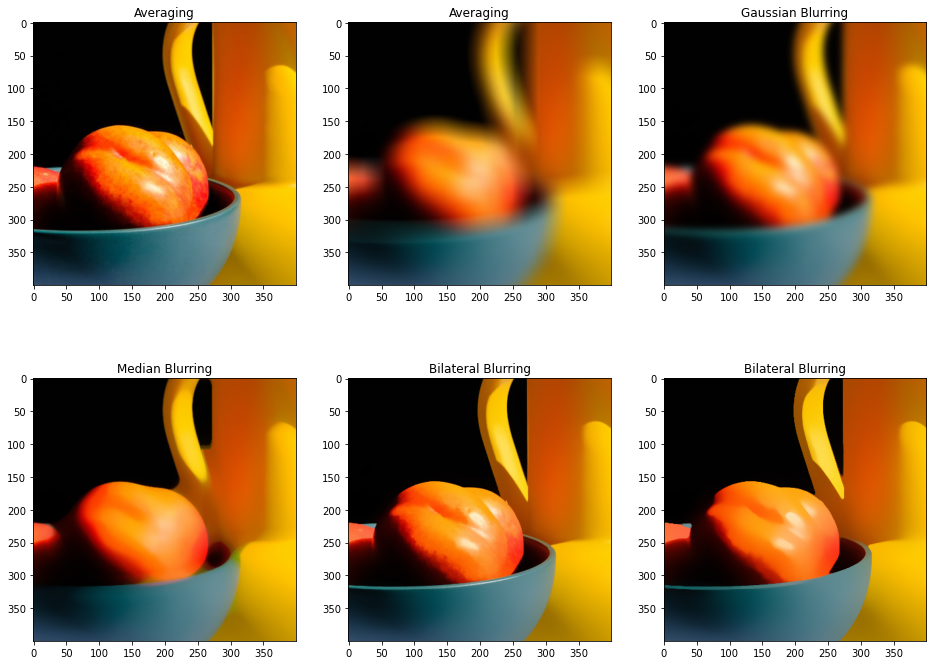

In [5]:
import cv2

ave_img = cv2.blur(img_arr, (35, 35)) # a 15 by 15 kernel size is used to calculate the average
gaus_img = cv2.GaussianBlur(img_arr, (35, 35), 0) # 0 indicates that the standard deviation must be calculated based on the kernel size
med_img = cv2.medianBlur(img_arr, 35)
med_img2 = cv2.medianBlur(img_arr, 7)
bilat_img = cv2.bilateralFilter(img_arr, 40, 50, 25)
processed_img = cv2.bilateralFilter(cv2.bilateralFilter(med_img2, 30, 50, 25), 45, 50, 25)

fig, ax = plt.subplots(2, 3 ,figsize=(16,12))
ax[0,0].imshow(img_arr[300:700, 300:700])
ax[0,0].set_title("Averaging")
ax[0,1].imshow(ave_img[300:700, 300:700])
ax[0,1].set_title("Averaging")
ax[0,2].imshow(gaus_img[300:700, 300:700])
ax[0,2].set_title("Gaussian Blurring")
ax[1,0].imshow(med_img[300:700, 300:700])
ax[1,0].set_title("Median Blurring")
ax[1,1].imshow(bilat_img[300:700, 300:700])
ax[1,1].set_title("Bilateral Blurring")
ax[1,2].imshow(processed_img[300:700, 300:700])
ax[1,2].set_title("Bilateral Blurring")

Both **averaging** and **Gaussian blurring** effectively remove local noise in the image, with **Gaussian blurring** doing so to a lesser degree. The one major drawback of these two methods is how it blurrs and blends the colors at the edges of the object. When quantising the image, blurred edges result in a gradient of colors between the two actual colors in the image, resulting a less realistic representation of the original image. On the other hand, **median blurring** effectively reduces noise and does not blur the edges of objects, but at certain places where multiple edges meet or where the shape of the edge is convex, a rounding effect occcurs. **Bilateral blurring** as expected maintains the clarity of the edges since these pixels are not included in the filtering, but is less effective at reducing local noise. The final picture shows how a small amount of **median blurring** combined with **bilateral filtering** can be used to obtain an image with reduced local noise and clearly defined edges. This combination provides the most desirable output, thus is selected as the most suitable smoothening method.

### 2. Quantising the Image
To simplify an image into a reduced set of colours, **clustering** could be used. **Clustering** is an unsupervised machine learning technique used to group/cluster unlabelled data such that each data point is assigned to only one group. For an image each pixel is a data point and the RGB color value are the features or independent variables. The most suitable clustering method for this task is **K-means Clustering**.

**K-means Clustering** seperates unlabelled data into *k* groups. Each group contains a cluster center and each data point is grouped to the cluster center with the minimum euclidean distance from itself. Initially the cluster centers are created randomly, either by picking *k* data points as the centers, or generating *k* random data points. The euclidean distance between each data point and each cluster center is computed and the data point is grouped to the cluster with the closest center to it. Although the data points have been successively grouped, the grouping is suboptimal as it depends on the initial location of cluster centers, which was picked randomly. To optimise and improve the location of the cluster centers, the average values of the data points in each cluster is calculated and used as the new cluster centers. This process is repeated until the distance between the data points and their cluster center converges. For images, the *k* cluster centers will be the reduced set of colors that can be used to accurately represent the image.

Typically, an important decision to be made when performing K-means Clustering is how many clusters to use. The Elbow Method is the standard practice for selecting the correct k value such that the model sufficiently seperates the data into groups but does not add extra groups which may be redundant in improving the models performance. The Elbow Method consists of iterating through different values of k and computing the sum of the squared error (distance between the data point and its cluster center). This error can be plotted against k to find the value of k where the error no longer reduces significantly. Later this method will be shown, but usually for paint-by-numbers either a fixed number of colors, k, would be used for all images, or may be defined by the individual based on the detail desired.

First we must import the required libraries:

In [6]:
from sklearn.cluster import KMeans

The image was imported as an array with each pixel containing the RGB values. The `KMeans()` function expects a 2 dimensional array, but as can be seen the image is a 3 dimensional array - width, height, and color. The first thing to do is to reshape the image into a 2-D array.

In [7]:
print("Shape of Image Array: ", processed_img.shape)
height, width, colors = processed_img.shape
img_2D = processed_img.reshape(height*width, colors)
print("Shape of Flattened Image Array: ", img_2D.shape)

Shape of Image Array:  (1000, 1000, 3)
Shape of Flattened Image Array:  (1000000, 3)


We can now create the model and then fit the model using the 2D image array with `fit_predict()` which also returns the labels for each pixel in the image.

In [8]:
from sklearn.cluster import KMeans

cluster_model = KMeans(n_clusters=12)
quant_labels = cluster_model.fit_predict(img_2D)
print("Number of pixel labels: ", len(quant_labels))

Number of pixel labels:  1000000


We can then get the cluster centers or the reduced set of colors using `cluster_centers_`. We convert the output to an interger as expected by the `imshow()` method.

In [9]:
quant_centers = cluster_model.cluster_centers_.round(0).astype(np.uint8)
print(quant_centers)

[[  1   1   1]
 [168 169 193]
 [240 184   6]
 [ 38  71  95]
 [183  80   1]
 [ 26  36  45]
 [252 192  76]
 [ 85 120 133]
 [187 135   1]
 [251 107  23]
 [183 189 224]
 [ 82  14   2]]


### 3. Recoloring the Image
Now that we have obtained the reduced set of colors (cluster centers) as well as the label for each pixel, we can recolor the image using the following code. Both the recolored image and the original image are shown for comparison.

Text(0.5, 1.0, 'Recolored Image')

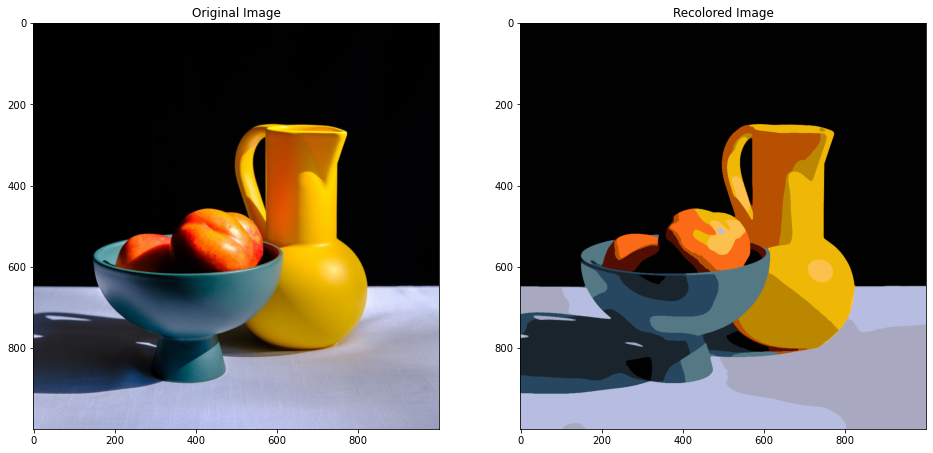

In [10]:
quantised_img = quant_centers[quant_labels].reshape(height, width, colors)

fig, ax = plt.subplots(1,2 ,figsize=(16,12))
ax[0].imshow(img_arr)
ax[0].set_title("Original Image")
ax[1].imshow(quantised_img)
ax[1].set_title("Recolored Image")

Now that we have shown how to quantise an image with *k* colors we can visualise the difference in the output with different values of *k*.

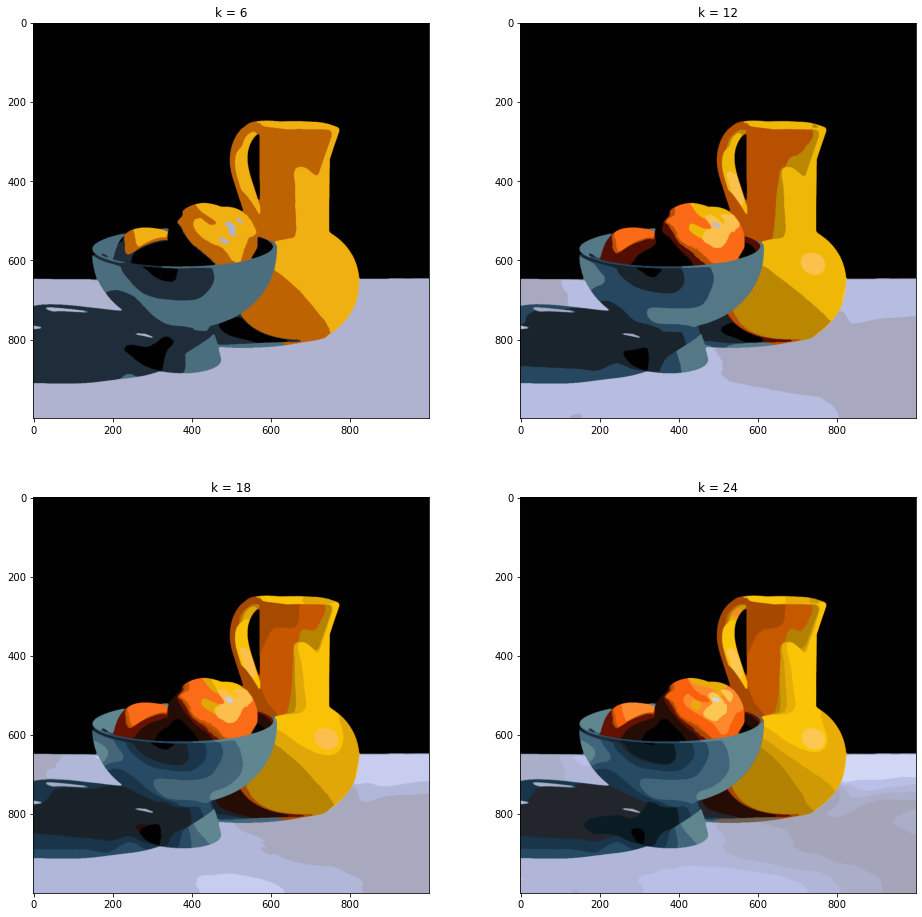

In [11]:
fig, ax = plt.subplots(2,2 ,figsize=(16,16))
inert = []
for k in range(6, 25):
    cluster_model = KMeans(n_clusters=k)
    data_labels = cluster_model.fit_predict(img_2D)
    cluster_centers = cluster_model.cluster_centers_.round(0).astype(np.uint8)
    new_img = cluster_centers[data_labels].reshape(height, width, colors)
    if k == 6:
        ax[0,0].imshow(new_img)
        ax[0,0].set_title(f"k = {k}")
    elif k == 12:
        ax[0,1].imshow(new_img)
        ax[0,1].set_title(f"k = {k}")
    elif k == 18:
        ax[1,0].imshow(new_img)
        ax[1,0].set_title(f"k = {k}")
    elif k == 24:
        ax[1,1].imshow(new_img)
        ax[1,1].set_title(f"k = {k}")
    inert.append(cluster_model.inertia_)

We can also visualise the inertia for different values of *k*. The inertia is simply the sum of the squared distances to the nearest cluster centers for each data point. As can be seen below there isn't a definitive **elbow point** for this image, but **k = 12** sufficiently represents the original image and will be used for the remainder of the notebook.

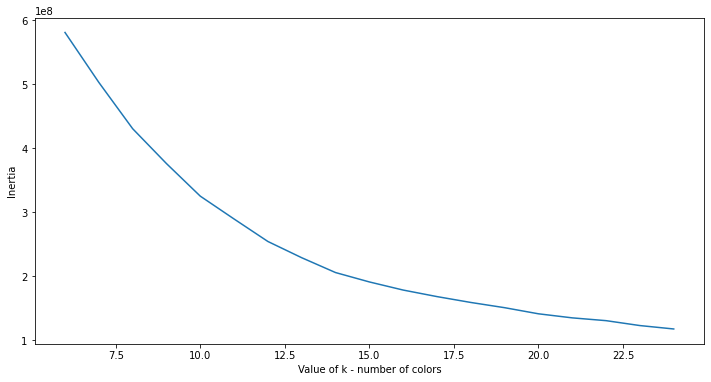

In [12]:
plt.figure(figsize=(12,6))
plt.plot(list(range(6,25)), inert)
plt.xlabel("Value of k - number of colors")
plt.ylabel("Inertia")
plt.show()

### 4. Outlining the Colored Sections

Before we outline all the sections, we are going to use another clustering method, called **DBSCAN**. This clustering method is a density based clustering method. The significant difference between **Kmeans** and **DBSCAN** is that **Kmeans** automatically creates circular/spherical clusters, whereas clusters found using **DBSCAN** can be any shape. This is important, as we now want to identify and seperate all sections, which can take any shape in the image not only based on color, but also on the position of the pixels. This is required so sections that are the same color but are not connected are seperated. This is crucial in later steps, when the sections are labelled with a number, so that the program does not attempt to label two of the same colored sections with a single label. In this method we used the labels of the image as the image to the **DBSCAN** method.

In [13]:
print(quant_labels)
print(len(quant_labels))

[0 0 0 ... 1 1 1]
1000000


In [14]:
labels_2d = np.array(quant_labels).reshape(height, width)
print(labels_2d.shape)

(1000, 1000)


Plotting the labels, shows how the labels represent the same image, but the colors have simply been replaced by their labels. Importantly, we can see that some seperate sections have the same labels and thus need to be seperately labelled later on.

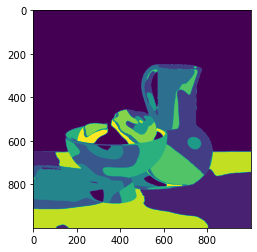

In [16]:
plt.imshow(labels_2d)

To seperate same colored sections in different locations, we will used their positional coordinates as well as their color label. The below code creates an array containing the positional information and the color label.

In [17]:
pos_labels_arr = np.zeros((height*width, 3), dtype=int)
print(pos_labels_arr.shape)

for index, label in np.ndenumerate(labels_2d):
    pos_labels_arr[width*index[0]+index[1], 0] = index[0]
    pos_labels_arr[width*index[0]+index[1], 1] = index[1]
    pos_labels_arr[width*index[0]+index[1], 2] = label
print(pos_labels_arr[-10:])

(1000000, 3)
[[999 990   1]
 [999 991   1]
 [999 992   1]
 [999 993   1]
 [999 994   1]
 [999 995   1]
 [999 996   1]
 [999 997   1]
 [999 998   1]
 [999 999   1]]


**DBSCAN** works by iterating through each point, using `eps` (mininmum distance to be considered a neighboring point) to calculate how many neighboring points each point has, and if it has at least the defined `min_samples`, then it is considered a **core point**. If one **core point** is a **neighboring point** of another **core point** then these two core points are clustered together. This is repeated for all points. Therefore, `eps` and `min_samples` are crucial to how effectively the clustering method works. In this project we want the same colored pixels that are adjacent to each other to be clustered together. At the same time, differently colored pixels that are adjacent to each other, and same colored pixels that are part of different sections must not be clustered together.

As such, for a pixel to be a core point it must have 9 same colored pixels including itself surrounding it. The minimum distance to ensure this is, distance of a diagonally adjacent pixel, which equates to square root 2 or rounded up to 1.415. This will ensure that an adjacent pixel of a different color will not be clusterd as the distance will exceed 1.415.

The following code generates the DBSCAN model, then fits the data to the model, returns the data labels, and lastly, the sizes of each cluster is printed out as an array with the first columnn containing the label and the second column containing the number of data points in that cluster.

In [18]:
from sklearn.cluster import DBSCAN

db_model = DBSCAN(eps=1.415, min_samples=9, metric='euclidean', algorithm='auto')
db_labels = db_model.fit_predict(pos_labels_arr)
unique, counts = np.unique(db_labels, return_counts=True)
label_counts = np.asarray((unique, counts)).T
print("DBSCAN labels: \n", label_counts)

DBSCAN labels: 
 [[    -1   4210]
 [     0 502106]
 [     1  44122]
 [     2  33082]
 [     3    100]
 [     4   3500]
 [     5    452]
 [     6   2877]
 [     7   3368]
 [     8   3466]
 [     9   1881]
 [    10     15]
 [    11    277]
 [    12  11854]
 [    13   2211]
 [    14    236]
 [    15     37]
 [    16   4966]
 [    17      7]
 [    18      9]
 [    19   1567]
 [    20   2205]
 [    21    180]
 [    22    939]
 [    23   3546]
 [    24     71]
 [    25    443]
 [    26   2610]
 [    27   4848]
 [    28    193]
 [    29    695]
 [    30  22312]
 [    31    881]
 [    32   2742]
 [    33     65]
 [    34   8363]
 [    35     12]
 [    36  25468]
 [    37   3057]
 [    38  25957]
 [    39    869]
 [    40   7378]
 [    41  18113]
 [    42   5104]
 [    43    141]
 [    44  49213]
 [    45   1897]
 [    46    616]
 [    47  87404]
 [    48     31]
 [    49    729]
 [    50     28]
 [    51   4067]
 [    52     14]
 [    53   2453]
 [    54     61]
 [    55     27]
 [    56      

The cluster labelled `-1` are actually the outliers, and are edge pixels between different sections. Similarly, there are many clusters with very few pixels, which are also most likely edge pixels. Since these are all near edges of sections and are too small too paint, they will be excluded from the remaining processes.

Below, the new labels can be shown side by side with the original labels, and we can see that same colored sections are now labelled differently.

Text(0.5, 1.0, 'Processed Image')

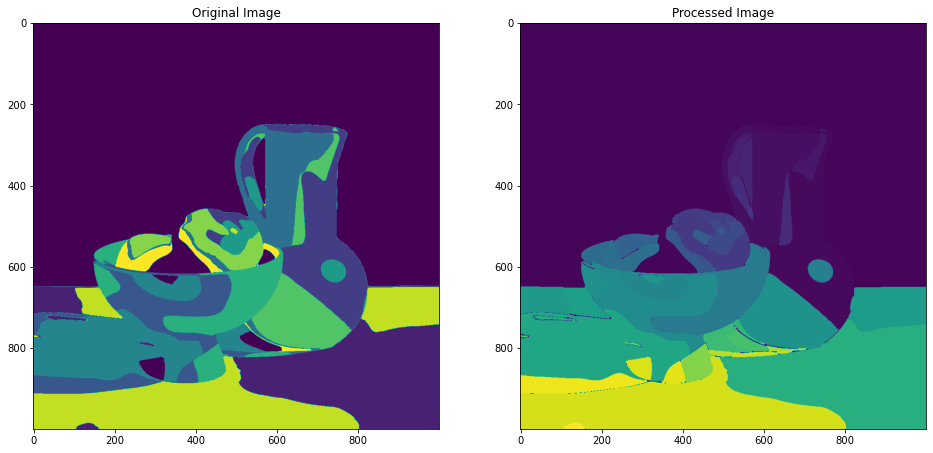

In [19]:
db_img = db_labels.reshape(height, width)
fig, ax = plt.subplots(1,2 ,figsize=(16,12))
ax[0].imshow(labels_2d)
ax[0].set_title("Original Image")
ax[1].imshow(db_img)
ax[1].set_title("Processed Image")

First we can begin with a blank image. To create the outlines on the blank image, we can simply iterate through each pixel of the quantised or labelled image and check how many of its neighboring pixels are the same color or label as it is. If the number is found to be less than 9, it forms part of the boundary between two sections. The pixel on the new image at the same location as the found boundary pixel can be made black or grey. After the iteration is complete, the resulting image is a black and white image with only the outlines of the different sections.

This process is coded below and the resulting outlined image is displayed.

Text(0.5, 1.0, 'Outlined Image')

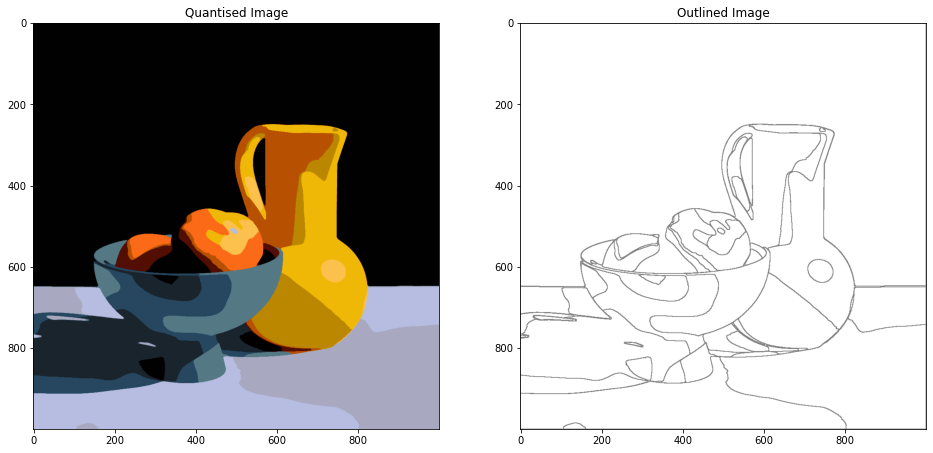

In [20]:
outlined_img = np.zeros(db_img.shape)

for index, label in np.ndenumerate(db_img):
    count = 0
    for loc, value in np.ndenumerate(db_img[index[0]-1:index[0]+2, index[1]-1:index[1]+2]):
        if value == label:
            count += 1
    if count < 9:
        outlined_img[index[0], index[1]] = 0.5
    else:
        outlined_img[index[0], index[1]] = 0.0

outlined_img[0, 0] = 1.0

fig, ax = plt.subplots(1,2 ,figsize=(16,12))
ax[0].imshow(quantised_img)
ax[0].set_title("Quantised Image")
ax[1].imshow(outlined_img, cmap="binary")
ax[1].set_title("Outlined Image")

### Labelling the Paint-by-Numbers

We have the colors and labels for each section, and have created an outlined image. All that is left is too label each section and provide a key to show which number corresponds to which color. To do this we need to find the center of each section, which is more challenging than it seems. If the mean pixel position of each section is used, we will end up with labels outside of the corresponding section for certain shapes. Similarly, the median pixel position may end up to close to the boundaries, making it difficult to read for the user. What we need to determine is the "visual" center of each section - position where the label appears as far away from any boundary as possible. The position is called the **center of inaccessibility**. On a map this would be the place that is the furthest away from a shoreline or borded as possible. Most methods of find this center require an excessive amount of computation. The **Polylabel algorithm** will be used, which requires significantly less computation to find an approximate or exact location of the **pole of inaccessibility** for each section of the image. 

The **Polylabel algorithm** performs the following:
1. Uses the the defined boundary of the polygon to define the bounding box of the polygon.
2. Store the location of the centroid and the minimum distance between the centroid and the boundary of the polygon as the BEST SO FAR.
2. Subdivides the bounding box into square cells.
3. Calculate the distance from the center of each cell to the boundary (negative distance if the center is outside of the polygon - detected using ray-casting).
4. Put cells into a priority queue sorted by the maximum potential distance (normalised distances due to differently sized cells).
5. Replace the BEST SO FAR with new location and distance to boundary if a cell center's distance to boundary is better than that of the previous BEST SO FAR.
6. Remove cells at the end of the queue as better potential cells are added.
7. Split cells with potentially better solutions if the *cell center distance to boundary - the BEST SO FAR > the desired precision*.

<img src="https://cloud.githubusercontent.com/assets/25395/16745865/864a0a30-47c0-11e6-87bc-58acac41a520.png" width="620" height="620" align="center"/>

As can be seen the the algorithm does not waste time or computation on positions with no potential, which significantly improves the speed at which a solution is found.

It is important to note, that this algorithm requires the boundary of the polygon to be defined. Luckily, this has already been addressed when outlining the image, this outlines just need to be stored using its label, which can be done using a dictionary.

In [21]:
border_dict = {}

for key in label_counts:
    if key[0] > -1 and key[1] > 40:
        border_dict[key[0]] = []
print(border_dict)

{0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 11: [], 12: [], 13: [], 14: [], 16: [], 19: [], 20: [], 21: [], 22: [], 23: [], 24: [], 25: [], 26: [], 27: [], 28: [], 29: [], 30: [], 31: [], 32: [], 33: [], 34: [], 36: [], 37: [], 38: [], 39: [], 40: [], 41: [], 42: [], 43: [], 44: [], 45: [], 46: [], 47: [], 49: [], 51: [], 53: [], 54: [], 58: [], 61: [], 65: [], 66: [], 67: [], 68: [], 69: [], 70: [], 71: [], 72: [], 73: [], 75: []}


The below code does the same iteration as was done to create the outlined image, but in this case, the pixels of the boundaries will be added to the dictionary using its corresponding DBSCAN label. In future code for creating the outlined image and storing the boundaries can be combined to save time.

In [22]:
for index, label in np.ndenumerate(db_img):
    count = 0
    for loc, value in np.ndenumerate(db_img[index[0]-1:index[0]+2, index[1]-1:index[1]+2]):
        if value == label:
            count += 1
    if count < 9:
        if label in border_dict.keys():
            border_dict[label].append([index[0], index[1]])

Although all the boundary pixels have been stored, they are in the wrong order. When shapes are defined, vertices must be presented in the way that they are connected by edges, in addition the last vertex must be the same as the first vertex to form a closed shape. The below code orders the vertices/pixels correctly as described.

In [23]:
poly_dict = {}
for key in border_dict:
    polygon = []
    while len(polygon) < len(border_dict[key]):
        for count, index in enumerate(border_dict[key]):
            if len(polygon) == 0:
                polygon.append(index)
            elif len(polygon) == 1:
                distance = ((polygon[-1][0]-index[0])**2 + (polygon[-1][1]-index[1])**2)**0.5
                if distance == 1:
                    polygon.append(index)
            else:
                distance = ((polygon[-1][0]-index[0])**2 + (polygon[-1][1]-index[1])**2)**0.5
                if distance == 1 and index != polygon[-2]:
                    polygon.append(index)
    polygon.append(polygon[0])
    poly_dict[key] = polygon
print(labels_2d[poly_dict[24][0][0], poly_dict[24][0][1]])

7


Now that all the boundaries have been correctly stored, the `polylabel` library can be used to find the **pole of inaccessibility** of each section. Thereafter, we add each **Kmeans label** for each section to the outlined image. Importantly, when sections are too small or narrow to fit a label (determined by the distance returned by `polylabel`), we add the label using a line and number contained in a bubble.

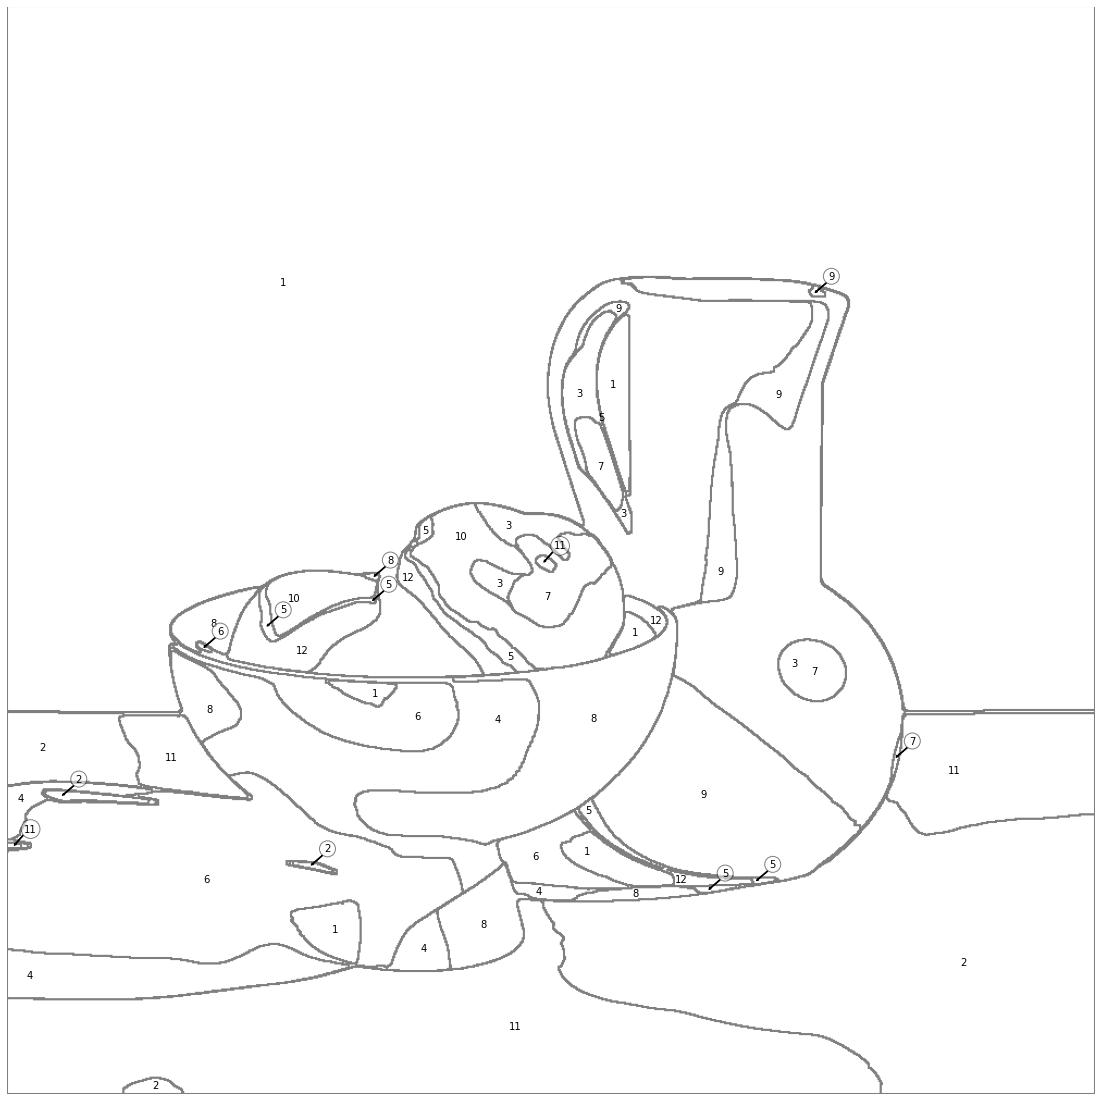

In [24]:
from polylabel import polylabel

plt.figure(figsize=(20,20))
plt.imshow(outlined_img, cmap='binary')

for key in poly_dict:
    center = polylabel([poly_dict[key]], precision=0.1, with_distance=True)
#     print(key, center[1], labels_2d[poly_dict[key][0][0], poly_dict[key][0][1]])
    if center[1] < 5.0:
        plt.annotate(text=f"{labels_2d[poly_dict[key][0][0], poly_dict[key][0][1]]+1}",
                     xy = (center[0][1], center[0][0]),
                     xytext=(center[0][1]+15, center[0][0]-15),
                     arrowprops=dict(width=0.75,
                                     facecolor='black', headwidth=2, headlength=2),
                     horizontalalignment='center',
                     verticalalignment='center',
                     color="black",
                     bbox=dict(boxstyle='circle', facecolor='white', edgecolor='black', alpha=0.5))
    else:
        plt.text(center[0][1], center[0][0], s=f"{labels_2d[poly_dict[key][0][0], poly_dict[key][0][1]]+1}", horizontalalignment='center', verticalalignment='center', color="black")
plt.axis("off")
plt.show()

The last action required is to provide the color chart showing the colors needed for each number.

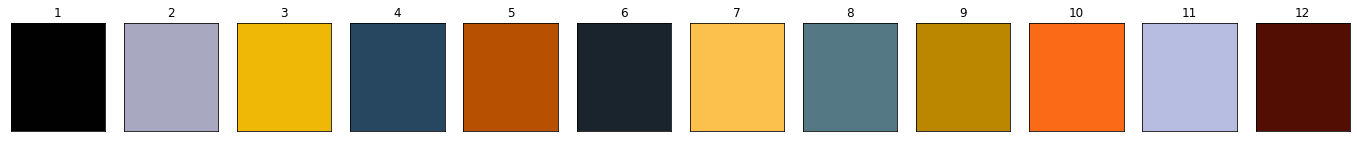

In [25]:
fig, ax = plt.subplots(1,12 ,figsize=(24,2))
for i in range(1,13):
    ax[i-1].set_facecolor(quant_centers[i-1]/255)
    ax[i-1].set_title(f'{i}')
    ax[i-1].get_xaxis().set_visible(False)
    ax[i-1].get_yaxis().set_visible(False)

### To-dos:
- Improve the speed of all the processes.
- Some issues with labelling where some sections completed enclosed by another section. Since this is not taken into account using Polylabel, labels for the outer section can sometimes be placed inside the enclosed section.